# LP-based Shadow Ban Policy

## Clone and Install if Using Cluster

In [ ]:
!git clone https://github.com/zlisto/opinion_dynamics
import os
os.chdir("opinion_dynamics")

# Add opinoin_dynamics. when importing scripts, eg, from opinion_dynamics.scripts.opinion_data import * # load twitter network

# Import Packages

In [1]:
import numpy as np
from scipy.optimize import linprog # linear programming solver

import networkx as nx # create synthetic network

from scripts.opinion_data import * # load twitter network
from scripts.dynamics_simulator import * # class for shadow ban LP optimization and RK simulation
from scripts.opinion_visualization import * # plot simulation results

import matplotlib.pyplot as plt
import time # check running time
import psutil # check CPU and memory usage

# Initialization

## Load Network

For your network `G` you need the following node features
   1. `rates` = array of posting rate of each node
   2. `opinions0` = array of initial opinions of each node

### Load Synthetic Network

In [ ]:
n0 = 20
nc = int(n0/2)
sizes = [nc, nc]
p0, p1 = 8/n0, 1/n0
probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
    G.nodes[i]['rate'] = 1
    G.nodes[i+nc]['rate'] = 1
fig = draw_network(G)

A = nx.adjacency_matrix(G)
A = A.tocoo()
assert n0 == A.shape[0]  #number of nodes in network should equal shape of A
rates = np.array([G.nodes[v]["rate"] for v in G.nodes()])  #posting rates of nodes
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])  #initial opinions of nodes

plt.hist(opinions0)
plt.show()

E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge


network_params = {'A':A, 'rates':rates, 'opinions0':opinions0, 'E':E}
network_params['data_name'] = 'synthetic'

network_params

### Load US Election Full Data

Mean rate 0.09730295339735406 tweets/day
CPU times: user 11.9 s, sys: 1.28 s, total: 13.2 s
Wall time: 15.8 s


{'A': <77563x77563 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'E': <77563x5022773 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'rates': array([0.01923077, 0.04166667, 0.01282051, ..., 0.04487179, 0.00961538,
        1.31089744]),
 'opinions0': array([0.62639551, 0.33246811, 0.17944451, ..., 0.24893551, 0.39323948,
        0.23936598]),
 'data_name': 'US Election'}

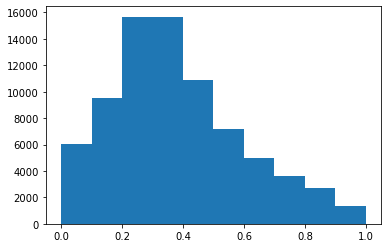

In [6]:
%%time
network_params = load_us_election()
network_params['data_name'] = 'US Election'

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

### Load Gilets Jaunes Full Data

Mean rate 0.49050534167547644 tweets/day
CPU times: user 6.61 s, sys: 647 ms, total: 7.25 s
Wall time: 9.13 s


{'A': <41501x41501 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'E': <41501x2257716 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'rates': array([0.33613445, 0.15966387, 0.04201681, ..., 0.33613445, 1.42016807,
        1.99159664]),
 'opinions0': array([0.43113284, 0.41007323, 0.20396378, ..., 0.76298056, 0.71444237,
        0.11448741]),
 'data_name': 'Gilets Jaunes'}

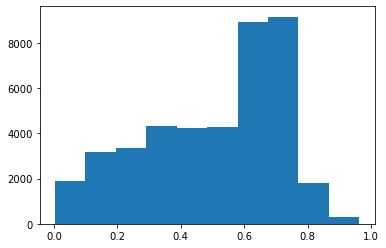

In [11]:
%%time
network_params = load_giletsjaunes()
network_params['data_name'] = 'Gilets Jaunes'

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

## Set Simulation and Optimization Parameters

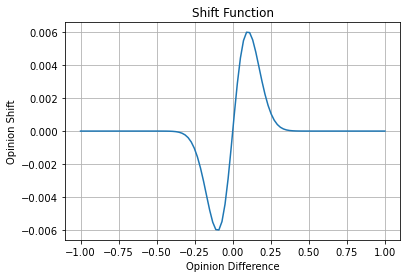

{'A': <41501x41501 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'E': <41501x2257716 sparse matrix of type '<class 'numpy.float64'>'
 	with 2257716 stored elements in COOrdinate format>,
 'rates': array([0.33613445, 0.15966387, 0.04201681, ..., 0.33613445, 1.42016807,
        1.99159664]),
 'opinions0': array([0.43113284, 0.41007323, 0.20396378, ..., 0.76298056, 0.71444237,
        0.11448741]),
 'data_name': 'Gilets Jaunes',
 'tau': 0.1,
 'omega': 0.1,
 'shift': <function __main__.shift(x)>,
 'Tf': 3,
 'control_steps': 3,
 'sim_steps': 3,
 'OBJECTIVE': 'MEAN',
 'smax': 0.5,
 'thres': 0.7}

In [12]:
#shift function
tau = 0.1
omega = 0.1

def shift(x):
    x = np.clip(x, -1, 1)
    y = omega*x*np.exp(-np.abs(x/tau)**2/2)
    
    return(y)

T_shift = np.linspace(-1,1,100)
plt.plot(T_shift, shift(T_shift))
plt.title('Shift Function')
plt.xlabel('Opinion Difference')
plt.ylabel('Opinion Shift')
plt.grid()
plt.show()


#for dynamics_simulator.py
Tf = 3 #final time of simulator [days]
control_steps = Tf #time points to optimize control
sim_steps = 3 #time points to simulate opinions within one control interval


#optimization parameters 
smax = 0.5 #max strength of shadow banning at any time
OBJECTIVE = 'MEAN' #integral cost type
thres = 0.7 #threshold used for EXTMIN and EXTMAX
assert OBJECTIVE in ['MEAN','VARMIN','VARMAX','EXTMIN','EXTMAX']

additional_params = {'tau': tau, 'omega': omega, 'shift': shift, 
                     'Tf': Tf, 'control_steps': control_steps, 'sim_steps': sim_steps, 
                     'OBJECTIVE': OBJECTIVE, 'smax': smax, 'thres': thres}


params = {**network_params, **additional_params}
nv = params['A'].shape[0]
ne = params['E'].shape[1]

params

## Check Relaxation Time

You want the minimum relaxation time (which is greater than zero) to be greater than your simulation discretization time (which is one hour in our case).

1. US Election - relaxation time min = 1.2e-2  hours, 25% = 0.7  hours, 50% = 2.5 hours, 75% = 13.2 hours

2. Gilets Jaunes - relaxation time min = 3.8e-3 hours, 25% = 0.9 hours, 50% = 13.3 hours


In [8]:
relaxation_time_hrs = pd.Series(24 / (params['rates']@params['A']))
relaxation_time_hrs[relaxation_time_hrs>0].describe()

<ipython-input-8-304aeab053fb>:1: RuntimeWarning: divide by zero encountered in divide
  relaxation_time_hrs = pd.Series(24 / (params['rates']@params['A']))


count    7.756300e+04
mean              inf
std               NaN
min      1.153160e-02
25%      7.220481e-01
50%      2.506024e+00
75%      1.315993e+01
max               inf
dtype: float64

# Optimize by LP and Simulate by RK

1. Optimize control by linear programming for `control_steps` control intervals
2. Solve state ivp by Runge-Kutta method for `sim_steps` within each control interval

Took 0.23 mins to simulate no ban
Took 0.36 mins to simulate ban VARMAX smax = 0.0
Took 0.38 mins to simulate ban VARMAX smax = 0.25
Took 0.44 mins to simulate ban VARMAX smax = 0.5
Took 0.46 mins to simulate ban VARMAX smax = 0.75
Took 0.39 mins to simulate ban VARMAX smax = 1.0


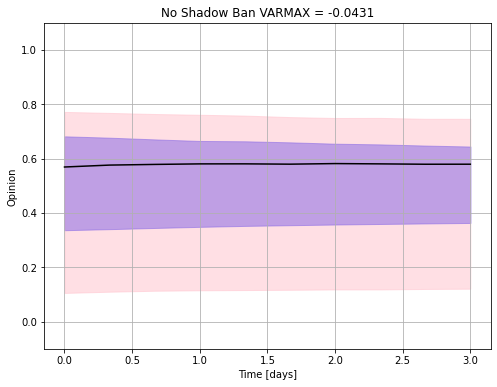

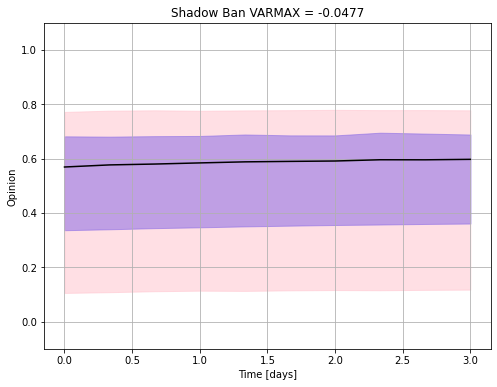

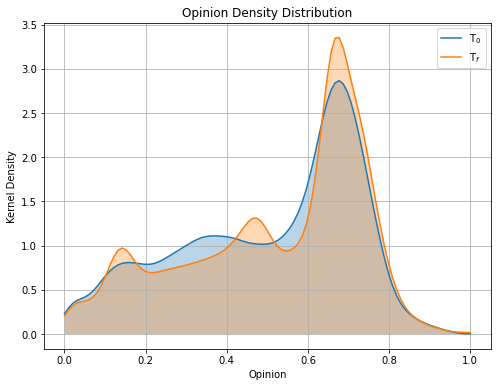

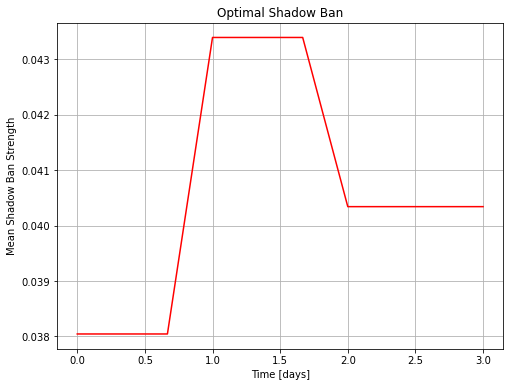

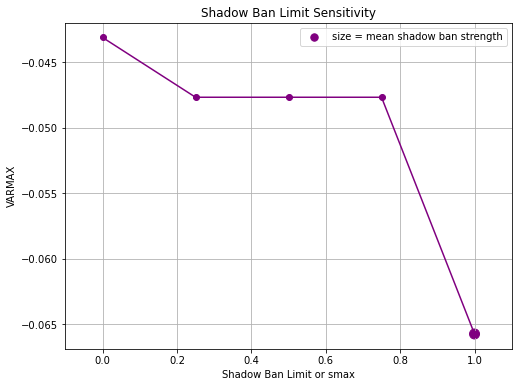

Memory usage: 4634.820608 mega bytes
CPU usage: 35.7 %
CPU times: user 1min 38s, sys: 20.5 s, total: 1min 58s
Wall time: 2min 29s


In [15]:
%%time

import cProfile
# Create a profiler object
profiler = cProfile.Profile()

# Start profiling
profiler.enable()



# no ban
start_time = time.time()
env_no_ban = OpinionSimulatorContinuous(params, False)
Opinions_no_ban, Controls_no_ban = opinion_simulation_list(env_no_ban)
print(f"Took {(time.time()-start_time)/60:.2f} mins to simulate no ban")

T = np.linspace(0, Tf, sim_steps*control_steps + 1) # for plots

# for OBJECTIVE in ['MEAN']:
for OBJECTIVE in ['VARMAX']:
# for OBJECTIVE in ['VARMIN']:
# for OBJECTIVE in ['EXTMAX']:
    params['OBJECTIVE'] = OBJECTIVE
    
    # objective of no ban
    obj_no_ban = cost_sim(OBJECTIVE, Opinions_no_ban, Controls_no_ban, thres=params['thres'])

    # plot no ban
    plt.figure(figsize = (8,6))
    plot_opinion_quantiles(T, Opinions_no_ban, U=Controls_no_ban)
    # plot_opinions(T, Opinions_no_ban)
    plt.ylim(-0.1, 1.1)
    plt.title(f"No Shadow Ban {OBJECTIVE} = {obj_no_ban:.4f}")
    plt.savefig(f"results/{params['data_name']}/No Shadow Ban {OBJECTIVE}.jpg", format="jpg")
    
    # save no ban
    np.savez(f"results/{params['data_name']}/No Shadow Ban {OBJECTIVE}.npz", 
             OBJECTIVE=params['OBJECTIVE'], tau=tau, omega=omega, Tf=Tf, T=T, obj=obj_no_ban, Opinions=Opinions_no_ban, 
             Controls=None)
        
    # smax sensitivity
    smax_range = np.arange(0.0, 1.1, 0.25)
    objs_ban = []
    means_ban = [] # bubble size for bubble plot
    for smax in smax_range:
        params['smax'] = smax

        # shadow ban
        start_time = time.time()
        env_ban = OpinionSimulatorContinuous(params, True)
        Opinions_ban, Controls_ban = opinion_simulation_list(env_ban)
        obj_ban = cost_sim(OBJECTIVE, Opinions_ban, Controls_ban, thres=params['thres'])

        print(f"Took {(time.time()-start_time)/60:.2f} mins to simulate ban {OBJECTIVE} smax = {smax}")

        mean_control = np.mean(Controls_ban)
        
        objs_ban.append(obj_ban)
        means_ban.append(1-mean_control)
        
        # plot smax == 0.5
        if smax == 0.5:
            plt.figure(figsize = (8,6))
            plot_opinion_quantiles(T, Opinions_ban, U=Controls_ban)
            # plot_opinions(T, Opinions_ban)
            plt.ylim(-0.1, 1.1)
            plt.title(f"Shadow Ban {OBJECTIVE} = {obj_ban:.4f}")
            plt.savefig(f"results/{params['data_name']}/Shadow Ban {OBJECTIVE}.jpg", format="jpg")            

            # density distribution shift
            plt.figure(figsize = (8,6))
            plot_density(Opinions_ban)
            plt.xlabel('Opinion')
            plt.ylabel('Kernel Density')
            plt.title('Opinion Density Distribution')
            plt.savefig(f"results/{params['data_name']}/Opinion Density {OBJECTIVE}.jpg", format="jpg")            
            
            # optimal mean ban over time
            plt.figure(figsize = (8,6))
            mean_control_time = np.mean(Controls_ban, axis=1)
            # T_plot = np.linspace(0,Tf,mean_control_time.shape[0])
            plt.plot(T, 1-mean_control_time, color = 'red')#, '.-', label='Mean Shadow Ban')
            plt.grid()
            plt.xlabel("Time [days]")
            plt.ylabel("Mean Shadow Ban Strength")
            plt.title(f"Optimal Shadow Ban")
            plt.savefig(f"results/{params['data_name']}/Optimal Shadow Ban {OBJECTIVE}.jpg", format="jpg")
            
            # save controls
            # transient controls
            T_tr = 1 # first couple of days
            T_tr = min(T_tr, Tf)
            tr_indices = np.arange(T_tr) * sim_steps # Calculate the indices of rows to extract

            # steady state controls
            T_ss = 1 # last couple of days
            T_ss = min(T_ss, Tf)
            ss_indices = np.arange(1, T_ss+1) * sim_steps # Calculate the indices of rows to extract

            np.savez(f"results/{params['data_name']}/Shadow Ban {params['OBJECTIVE']}_smax={params['smax']}_trss.npz", 
                     Controls_transient=Controls_ban[tr_indices,:], 
                     Controls_steady=Controls_ban[-1-ss_indices,:])
            
        # save shadow ban
        np.savez(f"results/{params['data_name']}/Shadow Ban {params['OBJECTIVE']}_smax={params['smax']}.npz", 
                 OBJECTIVE=params['OBJECTIVE'], tau=tau, omega=omega, Tf=Tf, T=T, obj=obj_ban, Opinions=Opinions_ban, 
                 Controls=np.mean(Controls_ban, axis=1))
            
    # plot smax sensitivity
    plt.figure(figsize = (8,6))
    plot_smax_sens(smax_range, objs_ban, means_ban)
    plt.xlabel("Shadow Ban Limit or smax")
    plt.ylabel(f"{OBJECTIVE}")
    plt.title(f"Shadow Ban Limit Sensitivity")
    plt.savefig(f"results/{params['data_name']}/Shadow Ban Limit Sensitivity {OBJECTIVE}.jpg", format="jpg")     
    np.savez(f"results/{params['data_name']}/Shadow Ban {params['OBJECTIVE']}_smax_sens.npz", 
             OBJECTIVE=params['OBJECTIVE'], tau=tau, omega=omega, Tf=Tf, T=T, 
             smax_range=smax_range, objs_ban=objs_ban, means_ban=means_ban)
    
    plt.show()
    
# Get memory usage
memory = psutil.virtual_memory()
print("Memory usage:", memory.used/10**6, "mega bytes")

# Get CPU usage
cpu_percent = psutil.cpu_percent(interval=10)
print("CPU usage:", cpu_percent, "%")


# Stop profiling
profiler.disable()

# Save the results to a file
profiler.dump_stats('profile_results.txt')

In [ ]:
import pstats

# Load the profiling results from the file
stats = pstats.Stats('profile_results.txt')

# Print the profiling results, sorted
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

In [10]:
data = np.load(f"results/{params['data_name']}/Shadow Ban {params['OBJECTIVE']}_smax=0.5_trss.npz")
data['obj']

array(-0.40495701)